In [1]:
'''
Build a suggorate model for the data
there is a DNN models that want to build
if there are 3 dataset, then there are 3 models after training
Example Code : https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=3
'''

'\nBuild a suggorate model for the data\nthere is a DNN models that want to build\nif there are 3 dataset, then there are 3 models after training\nExample Code : https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=3\n'

In [2]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Load data and do train test split
from sklearn.model_selection import KFold, cross_val_score, train_test_split


def load_data(filename, trainLabel, data_ml):
    # Load the data
    df = pd.read_csv(filename)
    
    X_predicted = df.drop(columns=['Label', trainLabel], axis=1)
    y_predicted = df[trainLabel]

    # Initial train test split set
    X_train_predicted, X_test_predicted, y_train_predicted, y_test_predicted = train_test_split(X_predicted, y_predicted, test_size=0.2, random_state=42, stratify=y_predicted)

    # Further split training set into training (70%) and validation (10%) sets
    X_train_predicted, X_val_predicted, y_train_predicted, y_val_predicted = train_test_split(X_train_predicted, y_train_predicted, test_size=0.1, random_state=42, stratify=y_train_predicted)
    
    # save datasets
    train_predicted = pd.concat([X_train_predicted, y_train_predicted], axis=1)
    val_predicted = pd.concat([X_val_predicted, y_val_predicted], axis=1)
    test_predicted = pd.concat([X_test_predicted, y_test_predicted], axis=1)
    train_predicted.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/train_{data_ml}_predicted.csv', index=False) 
    val_predicted.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/val_lr_{data_ml}_predicted.csv', index=False)
    test_predicted.to_csv(f'../datasets/surrogate_model/CICIDS2017/split_dataset/test_lr_{data_ml}_predicted.csv', index=False)
    
    return X_train_predicted, X_val_predicted, X_test_predicted, y_train_predicted, y_val_predicted, y_test_predicted

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

def draw_plot(accuracy_stats, loss_stats):
    # print("acc: ", accuracy_stats)
    # print("loss: ", loss_stats)
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

    print(train_val_acc_df)
    print(train_val_loss_df)
    # modify column names
    train_val_acc_df.columns = ['epochs', 'status', 'accuracy']
    train_val_loss_df.columns = ['epochs', 'status', 'loss']
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="accuracy", hue="status",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="loss", hue="status", ax=axes[1]).set_title('Train-Val Loss/Epoch')


In [19]:
from sklearn.metrics import confusion_matrix

# draw confusion matrix
def draw_confusion_matrix(y_test, y_pred, model, model_name, dataset_resource):
    cm = confusion_matrix(y_test, y_pred)
    total = np.sum(cm)
    confusion_percentage = (cm  / total) * 100

    strings = np.asarray([['%', '%'],
                        ['%', '%']])
    labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 10})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix of {model_name} Surrogate Model', fontsize=15)
    # add accuracy
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.text(0.5, 2.5, f'Dataset from: {dataset_resource}', dict(size=12))
    
    plt.show()

In [6]:
# Load data and do train test split
X_train_lr_predicted, X_val_lr_predicted, X_test_lr_predicted, y_train_lr_predicted, y_val_lr_predicted, y_test_lr_predicted = load_data('../surrogate_model/data_for_training/df_lr_predicted_0313.csv', 'LR_Predicted', 'lr')
X_train_dt_predicted, X_val_dt_predicted, X_test_dt_predicted, y_train_dt_predicted, y_val_dt_predicted, y_test_dt_predicted = load_data('../surrogate_model/data_for_training/df_dt_predicted_0313.csv', 'DT_Predicted', 'dt')
X_train_xgb_predicted, X_val_xgb_predicted, X_test_xgb_predicted, y_train_xgb_predicted, y_val_xgb_predicted, y_test_xgb_predicted = load_data('../surrogate_model/data_for_training/df_xgb_predicted_0313.csv', 'XGB_Predicted', 'dt')
X_train_dnn_predicted, X_val_dnn_predicted, X_test_dnn_predicted, y_train_dnn_predicted, y_val_dnn_predicted, y_test_dnn_predicted = load_data('../surrogate_model/data_for_training/df_dnn_predicted_0313.csv', 'DNN_Predicted', 'dnn')

In [7]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.tensor(np.array(X_train_dt_predicted)).float(), torch.tensor(np.array(y_train_dt_predicted)).long())
val_dataset = ClassifierDataset(torch.tensor(np.array(X_val_dt_predicted)).float(), torch.tensor(np.array(y_val_dt_predicted)).long())
test_dataset = ClassifierDataset(torch.tensor(np.array(X_test_dt_predicted)).float(), torch.tensor(np.array(y_test_dt_predicted)).long())

In [8]:
# Hyperparameters
input_size = len(X_train_xgb_predicted.columns) # 42
num_classes = 2
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [9]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [10]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from datetime import datetime

# Here we create our simple neural network. For more details here we are subclassing and
# inheriting from nn.Module, this is the most general way to create your networks and
# allows for more flexibility. I encourage you to also check out nn.Sequential which
# would be easier to use in this scenario but I wanted to show you something that
# "always" works and is a general approach.
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(DNN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        # self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        
        self.relu = nn.ReLU()
        self.act3 = nn.Softmax()
        self.batchnorm1 = nn.BatchNorm1d(128)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """

        #x = F.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize network
model = DNN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# accuracy, loss status for each epoch
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}


print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train Network
for epoch in range(num_epochs):
    
    # train model
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        #data = data.reshape(data.shape[0], -1)

        # Forward
        y_train_pred = model(data)
        
        # train_loss, train_acc per batch
        train_loss = criterion(y_train_pred, targets) 
        train_acc  = (y_train_pred.argmax(1) == targets).float().sum() / len(targets)
        
        # Backward
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        train_epoch_loss += train_loss.item()   
        train_epoch_acc += train_acc.item()
        


    # validate model
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            val_loss = criterion(voutputs, vlabels)
            val_acc = (voutputs.argmax(1) == vlabels).float().sum() / len(vlabels)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    avg_vloss = val_epoch_loss/len(val_loader)


    # save the accuracy and loss for each epoch   
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../surrogate_model/surrogate_DNN_model/surrogateDNN_model_{}_{}'.format(timestamp, epoch) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
        
    print(f'Epoch {epoch + 1}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_epoch_acc/len(val_loader):.4f}')

        

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model

    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
           # x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")


Begin training.


100%|██████████| 1354/1354 [00:02<00:00, 622.83it/s]


Epoch 1: | Train Loss: 0.38025 | Val Loss: 0.32623 | Train Acc: 0.8662| Val Acc: 0.8843


100%|██████████| 1354/1354 [00:02<00:00, 621.53it/s]


Epoch 2: | Train Loss: 0.34659 | Val Loss: 0.31312 | Train Acc: 0.8864| Val Acc: 0.8955


100%|██████████| 1354/1354 [00:02<00:00, 616.96it/s]


Epoch 3: | Train Loss: 0.33932 | Val Loss: 0.30629 | Train Acc: 0.8889| Val Acc: 0.8983


100%|██████████| 1354/1354 [00:02<00:00, 611.42it/s]


Epoch 4: | Train Loss: 0.33361 | Val Loss: 0.30249 | Train Acc: 0.8906| Val Acc: 0.9012


100%|██████████| 1354/1354 [00:02<00:00, 626.13it/s]


Epoch 5: | Train Loss: 0.32620 | Val Loss: 0.29343 | Train Acc: 0.8931| Val Acc: 0.9011


100%|██████████| 1354/1354 [00:02<00:00, 638.54it/s]


Epoch 6: | Train Loss: 0.31989 | Val Loss: 0.29157 | Train Acc: 0.8949| Val Acc: 0.9017


100%|██████████| 1354/1354 [00:02<00:00, 636.27it/s]


Epoch 7: | Train Loss: 0.31483 | Val Loss: 0.28255 | Train Acc: 0.8966| Val Acc: 0.9013


100%|██████████| 1354/1354 [00:02<00:00, 619.72it/s]


Epoch 8: | Train Loss: 0.30918 | Val Loss: 0.28098 | Train Acc: 0.8973| Val Acc: 0.9014


100%|██████████| 1354/1354 [00:02<00:00, 617.64it/s]


Epoch 9: | Train Loss: 0.30148 | Val Loss: 0.27161 | Train Acc: 0.8990| Val Acc: 0.9045


100%|██████████| 1354/1354 [00:02<00:00, 629.54it/s]


Epoch 10: | Train Loss: 0.29768 | Val Loss: 0.27031 | Train Acc: 0.9010| Val Acc: 0.9029


100%|██████████| 1354/1354 [00:02<00:00, 621.82it/s]


Epoch 11: | Train Loss: 0.29923 | Val Loss: 0.26168 | Train Acc: 0.9010| Val Acc: 0.9053


100%|██████████| 1354/1354 [00:02<00:00, 585.25it/s]


Epoch 12: | Train Loss: 0.28859 | Val Loss: 0.25793 | Train Acc: 0.9036| Val Acc: 0.9077


100%|██████████| 1354/1354 [00:02<00:00, 610.60it/s]


Epoch 13: | Train Loss: 0.28767 | Val Loss: 0.25150 | Train Acc: 0.9039| Val Acc: 0.9079


100%|██████████| 1354/1354 [00:02<00:00, 601.37it/s]


Epoch 14: | Train Loss: 0.28674 | Val Loss: 0.25021 | Train Acc: 0.9053| Val Acc: 0.9080


100%|██████████| 1354/1354 [00:02<00:00, 612.08it/s]


Epoch 15: | Train Loss: 0.28289 | Val Loss: 0.24218 | Train Acc: 0.9066| Val Acc: 0.9077


100%|██████████| 1354/1354 [00:02<00:00, 600.17it/s]


Epoch 16: | Train Loss: 0.27617 | Val Loss: 0.24547 | Train Acc: 0.9090| Val Acc: 0.9095


100%|██████████| 1354/1354 [00:02<00:00, 566.76it/s]


Epoch 17: | Train Loss: 0.27356 | Val Loss: 0.22943 | Train Acc: 0.9101| Val Acc: 0.9121


100%|██████████| 1354/1354 [00:02<00:00, 602.52it/s]


Epoch 18: | Train Loss: 0.26500 | Val Loss: 0.22447 | Train Acc: 0.9133| Val Acc: 0.9127


100%|██████████| 1354/1354 [00:02<00:00, 597.09it/s]


Epoch 19: | Train Loss: 0.26065 | Val Loss: 0.23153 | Train Acc: 0.9143| Val Acc: 0.9153


100%|██████████| 1354/1354 [00:02<00:00, 604.33it/s]


Epoch 20: | Train Loss: 0.26117 | Val Loss: 0.22498 | Train Acc: 0.9144| Val Acc: 0.9134


100%|██████████| 1354/1354 [00:02<00:00, 540.32it/s]


Epoch 21: | Train Loss: 0.27958 | Val Loss: 0.24915 | Train Acc: 0.9121| Val Acc: 0.9122


100%|██████████| 1354/1354 [00:02<00:00, 608.81it/s]


Epoch 22: | Train Loss: 0.26774 | Val Loss: 0.22117 | Train Acc: 0.9149| Val Acc: 0.9156


100%|██████████| 1354/1354 [00:02<00:00, 621.81it/s]


Epoch 23: | Train Loss: 0.25727 | Val Loss: 0.21675 | Train Acc: 0.9165| Val Acc: 0.9155


100%|██████████| 1354/1354 [00:02<00:00, 620.23it/s]


Epoch 24: | Train Loss: 0.25096 | Val Loss: 0.21743 | Train Acc: 0.9185| Val Acc: 0.9184


100%|██████████| 1354/1354 [00:02<00:00, 610.34it/s]


Epoch 25: | Train Loss: 0.24653 | Val Loss: 0.20758 | Train Acc: 0.9198| Val Acc: 0.9186


100%|██████████| 1354/1354 [00:02<00:00, 620.21it/s]


Epoch 26: | Train Loss: 0.25103 | Val Loss: 0.20185 | Train Acc: 0.9201| Val Acc: 0.9209


100%|██████████| 1354/1354 [00:02<00:00, 621.10it/s]


Epoch 27: | Train Loss: 0.24807 | Val Loss: 0.21243 | Train Acc: 0.9210| Val Acc: 0.9206


100%|██████████| 1354/1354 [00:02<00:00, 595.55it/s]


Epoch 28: | Train Loss: 0.24950 | Val Loss: 0.22720 | Train Acc: 0.9208| Val Acc: 0.9159


100%|██████████| 1354/1354 [00:02<00:00, 615.87it/s]


Epoch 29: | Train Loss: 0.24080 | Val Loss: 0.19515 | Train Acc: 0.9228| Val Acc: 0.9247


100%|██████████| 1354/1354 [00:02<00:00, 618.69it/s]


Epoch 30: | Train Loss: 0.23877 | Val Loss: 0.20321 | Train Acc: 0.9232| Val Acc: 0.9227


100%|██████████| 1354/1354 [00:02<00:00, 625.26it/s]


Epoch 31: | Train Loss: 0.24075 | Val Loss: 0.18901 | Train Acc: 0.9233| Val Acc: 0.9274


100%|██████████| 1354/1354 [00:02<00:00, 619.82it/s]


Epoch 32: | Train Loss: 0.23236 | Val Loss: 0.19394 | Train Acc: 0.9266| Val Acc: 0.9265


100%|██████████| 1354/1354 [00:02<00:00, 621.39it/s]


Epoch 33: | Train Loss: 0.23503 | Val Loss: 0.19954 | Train Acc: 0.9264| Val Acc: 0.9256


100%|██████████| 1354/1354 [00:02<00:00, 621.53it/s]


Epoch 34: | Train Loss: 0.23411 | Val Loss: 0.18582 | Train Acc: 0.9258| Val Acc: 0.9283


100%|██████████| 1354/1354 [00:02<00:00, 626.56it/s]


Epoch 35: | Train Loss: 0.23157 | Val Loss: 0.18294 | Train Acc: 0.9276| Val Acc: 0.9317


100%|██████████| 1354/1354 [00:02<00:00, 624.46it/s]


Epoch 36: | Train Loss: 0.23492 | Val Loss: 0.18331 | Train Acc: 0.9274| Val Acc: 0.9297


100%|██████████| 1354/1354 [00:02<00:00, 607.03it/s]


Epoch 37: | Train Loss: 0.22911 | Val Loss: 0.19137 | Train Acc: 0.9282| Val Acc: 0.9270


100%|██████████| 1354/1354 [00:02<00:00, 614.76it/s]


Epoch 38: | Train Loss: 0.22955 | Val Loss: 0.19078 | Train Acc: 0.9277| Val Acc: 0.9337


100%|██████████| 1354/1354 [00:02<00:00, 620.96it/s]


Epoch 39: | Train Loss: 0.22731 | Val Loss: 0.17715 | Train Acc: 0.9288| Val Acc: 0.9402


100%|██████████| 1354/1354 [00:02<00:00, 626.71it/s]


Epoch 40: | Train Loss: 0.22262 | Val Loss: 0.17308 | Train Acc: 0.9302| Val Acc: 0.9464


100%|██████████| 1354/1354 [00:02<00:00, 626.71it/s]


Epoch 41: | Train Loss: 0.22628 | Val Loss: 0.20843 | Train Acc: 0.9306| Val Acc: 0.9315


100%|██████████| 1354/1354 [00:02<00:00, 617.00it/s]


Epoch 42: | Train Loss: 0.23943 | Val Loss: 0.17967 | Train Acc: 0.9284| Val Acc: 0.9389


100%|██████████| 1354/1354 [00:02<00:00, 615.03it/s]


Epoch 43: | Train Loss: 0.24191 | Val Loss: 0.20631 | Train Acc: 0.9284| Val Acc: 0.9238


100%|██████████| 1354/1354 [00:02<00:00, 628.40it/s]


Epoch 44: | Train Loss: 0.22508 | Val Loss: 0.17870 | Train Acc: 0.9305| Val Acc: 0.9362


100%|██████████| 1354/1354 [00:02<00:00, 627.30it/s]


Epoch 45: | Train Loss: 0.22226 | Val Loss: 0.19931 | Train Acc: 0.9307| Val Acc: 0.9326


100%|██████████| 1354/1354 [00:02<00:00, 630.08it/s]


Epoch 46: | Train Loss: 0.22722 | Val Loss: 0.18356 | Train Acc: 0.9302| Val Acc: 0.9355


100%|██████████| 1354/1354 [00:02<00:00, 620.61it/s]


Epoch 47: | Train Loss: 0.21680 | Val Loss: 0.18504 | Train Acc: 0.9326| Val Acc: 0.9362


100%|██████████| 1354/1354 [00:02<00:00, 630.80it/s]


Epoch 48: | Train Loss: 0.22147 | Val Loss: 0.17926 | Train Acc: 0.9308| Val Acc: 0.9389


100%|██████████| 1354/1354 [00:02<00:00, 621.25it/s]


Epoch 49: | Train Loss: 0.21916 | Val Loss: 0.17524 | Train Acc: 0.9316| Val Acc: 0.9420


100%|██████████| 1354/1354 [00:02<00:00, 615.32it/s]


Epoch 50: | Train Loss: 0.22180 | Val Loss: 0.17650 | Train Acc: 0.9319| Val Acc: 0.9434
Accuracy on training set: 94.43
Accuracy on test set: 94.51


    epochs variable     value
0        0    train  0.866184
1        1    train  0.886401
2        2    train  0.888859
3        3    train  0.890590
4        4    train  0.893060
..     ...      ...       ...
95      45      val  0.935541
96      46      val  0.936164
97      47      val  0.938862
98      48      val  0.941976
99      49      val  0.943430

[100 rows x 3 columns]
    epochs variable     value
0        0    train  0.380250
1        1    train  0.346591
2        2    train  0.339323
3        3    train  0.333611
4        4    train  0.326202
..     ...      ...       ...
95      45      val  0.183556
96      46      val  0.185041
97      47      val  0.179264
98      48      val  0.175236
99      49      val  0.176504

[100 rows x 3 columns]


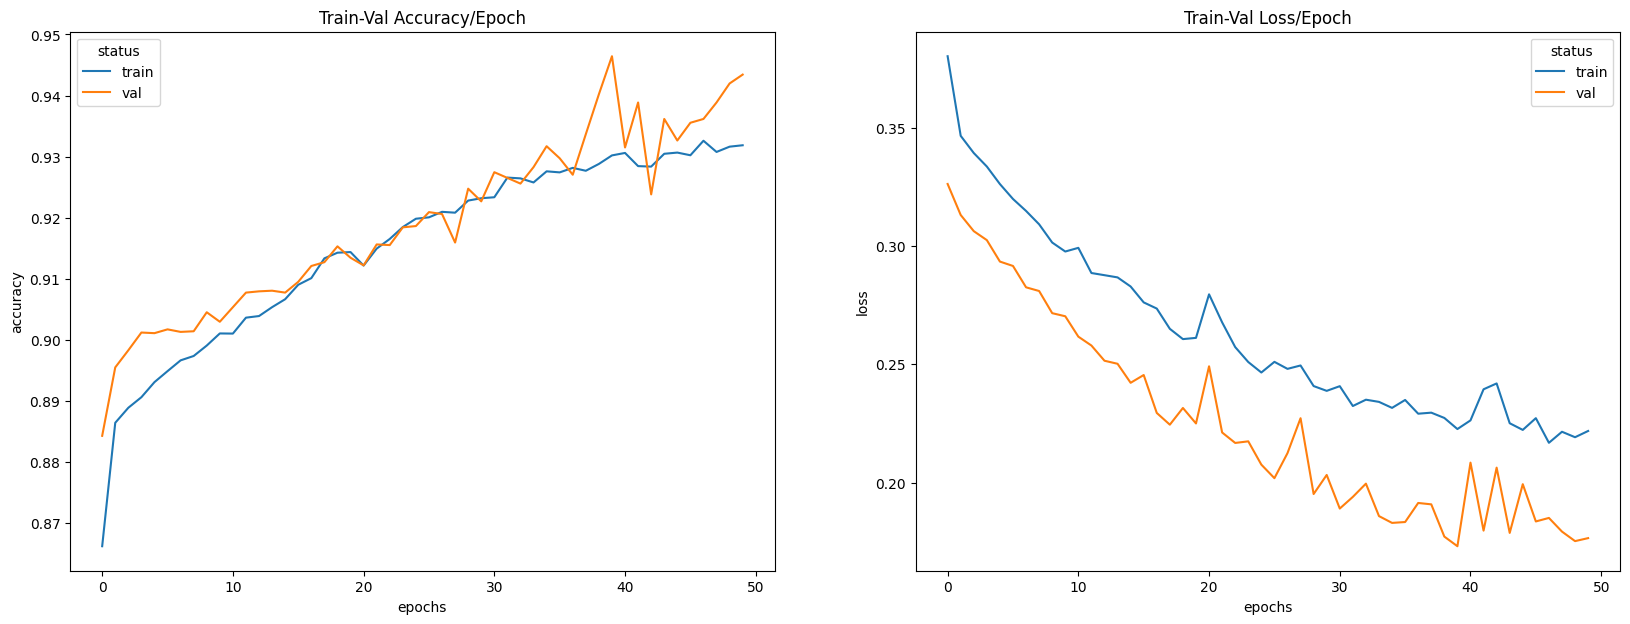

In [11]:
# Draw the plot
draw_plot(accuracy_stats, loss_stats)

In [12]:
# test the model

def test_model(loader, model):
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            #print(_, y_pred_tags.cpu().numpy())
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_pred_list

y_pred_list = test_model(test_loader, model)

In [13]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("accuracy of test data: ", accuracy_score(y_test_dt_predicted, y_pred_list))
print(classification_report(y_test_dt_predicted, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

accuracy of test data:  0.9451110649782022
              precision    recall  f1-score   support

      Benign     0.9435    0.9853    0.9639     17930
   Malicious     0.9508    0.8281    0.8852      6155

    accuracy                         0.9451     24085
   macro avg     0.9471    0.9067    0.9246     24085
weighted avg     0.9454    0.9451    0.9438     24085



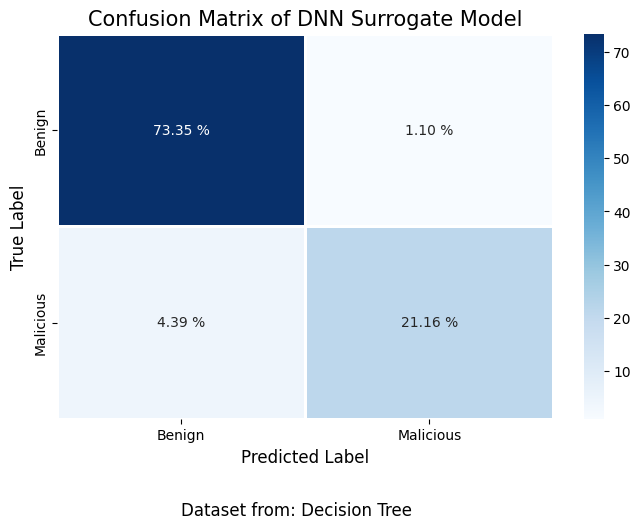

In [20]:
# draw confusion matrix
draw_confusion_matrix(y_test_dt_predicted, y_pred_list, model, 'DNN', 'Decision Tree')